# Benchmarking HQNN using the Spiral dataset

Here, we want to reproduce similar experiments as in [Computational Advantage in Hybrid Quantum Neural Networks: Myth or Reality](https://arxiv.org/abs/2412.04991). Therefore, we create a toy dataset, the *spiral dataset* for which we can increase the complexity. We observe the minimum model required to reach at least a given threshold of accuracy.

In [1]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import merlin as ML  # Using our Merlin framework
import math
import json
import os
from torch.utils.data import DataLoader, TensorDataset
import perceval as pcvl
from merlin.datasets import spiral
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from typing import List


from sklearn import svm
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### 1. Dataset

In vis: X = (999, 20), y = (999,)
Training set = (799, 20) and Test set = (200, 20)
['Class 0', 'Class 1', 'Class 2']


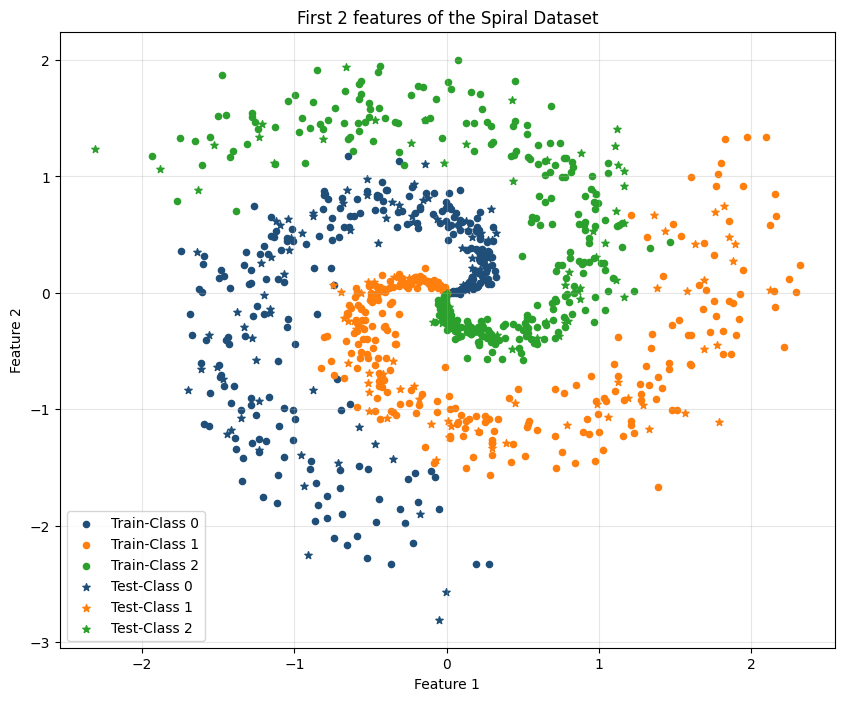

In [2]:
# load the data
def load_spiral(samples = 1000, features = 20, classes = 3):
    X, y, md = spiral.get_data(
                     num_instances=samples,
                     num_features=features,
                     num_classes=classes,
        )

    # split in training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # create dataset and DataLoaders
    train_dataset = TensorDataset(torch.tensor(X_train, dtype = torch.float32), torch.tensor(y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
    val_dataset = TensorDataset(torch.tensor(X_val, dtype = torch.float32), torch.tensor(y_val, dtype=torch.long))
    val_loader = DataLoader(val_dataset, batch_size=BS)

    return train_loader, val_loader

# display the data
def visualize_spiral_dataset_2d(samples = 1000, features = 20, classes = 3):
    X, y, md = spiral.get_data(
                     num_instances=samples,
                     num_features=features,
                     num_classes=classes,
        )
    print(f"In vis: X = {X.shape}, y = {y.shape}")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Training set = {X_train.shape} and Test set = {X_test.shape}")
    # For 2D visualization
    plt.figure(figsize=(10, 8))
    class_names = [f"Class {i}" for i in range(len(np.unique(y_train)))]
    print(class_names)
    # Plot each class separately to create a proper legend
    colors = ['#1f4e79', '#ff7f0e', '#2ca02c']
    for i, class_name in enumerate(class_names):
        idx = np.where(y_train == i)
        plt.scatter(X_train[idx, 0], X_train[idx, 1], label=f"Train-{class_name}", s=20, c = colors[i])#, alpha=0.8)
    for i, class_name in enumerate(class_names):
        idx = np.where(y_test == i)
        plt.scatter(X_test[idx, 0], X_test[idx, 1], label=f"Test-{class_name}", s=30, marker = "*", c = colors[i])#, alpha=0.8)

    plt.title(f"First 2 features of the Spiral Dataset")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig("./results/blobs_dataset.png")
    plt.show()

    return X, y

# visualize the first 2 features of the spiral dataset
X_2d, y_2d = visualize_spiral_dataset_2d()

In [3]:
# we fix the parameters for the dataset
NB_CLASSES = 3
NB_SAMPLES = 1250
BS = 64

## 2. Now, we generate a list of hybrid photonic quantum NN that we want to test on our data

In [30]:
# function to define a circuit with m modes and an encoding layer for an input with a given size
def create_quantum_circuit(m, size = 400):
    """Create quantum circuit with specified number of modes

        Args:
            m (int): number of modes
            size (int): size of the input data
            frequency (int): frequency of the repetition of the {encoding layers with input data in phase shifters; trainable generic interferometer}
    """

    # first trainable generic interferometer
    # here, we train both beam splitters and phase shifters
    wl = pcvl.GenericInterferometer(m,
                                    lambda i: pcvl.BS(theta=pcvl.P(f"bs_1_{i}")) // pcvl.PS(pcvl.P(f"ps_1_{i}")) // \
                                              pcvl.BS(theta=pcvl.P(f"bs_2_{i}")) // pcvl.PS(pcvl.P(f"ps_2_{i}")),
                                    shape=pcvl.InterferometerShape.RECTANGLE)

    c = pcvl.Circuit(m)
    c.add(0, wl, merge=True)

    # encoding layers with input data in phase shifters
    c_var = pcvl.Circuit(m)
    for i in range(size):
        px = pcvl.P(f"px-{i + 1}")
        c_var.add(i%m, pcvl.PS(px))
    c.add(0, c_var, merge=True)

    # second trainable generic interferometer
    # here, we only train the phase shifters
    wr = pcvl.GenericInterferometer(m,
                                    lambda i: pcvl.BS() // pcvl.PS(pcvl.P(f"ps_3_{i}")) // \
                                              pcvl.BS() // pcvl.PS(pcvl.P(f"ps_4_{i}")),
                                    shape=pcvl.InterferometerShape.RECTANGLE)



    c.add(0, wr, merge=True)

    return c

# here, we generate all the sets (modes, nb of photons)
def generate_architectures() -> List[List[int]]:
    """Generate different QLayer architectures varying modes and number of phototons"""
    architectures = []
    # Modes to try
    modes = [2,4,6,8,10]
    for mode in modes:
        nb_photons_max = mode // 2
        for photons_count in range(1, nb_photons_max + 1):
            architectures.append([mode,photons_count])

    return architectures

# now, we sort them by number of parameters
def sort_architecture(NB_FEATURES,OUTPUT_FEATURES):
    # generate all architectures
    architectures = generate_architectures()

    # initiate the list that will contain the (modes, photons, param count)
    arch_with_params = []
    for mode, nb_photons in architectures:
        input_state = [0] * mode

        for k in range(nb_photons):
            input_state[2 * k] = 1

        # circuit
        circuit = create_quantum_circuit(mode, size=NB_FEATURES)
        # count trainable parameter in circuit
        trainable_parameters_qlayer = len([p.name for p in circuit.get_parameters() if
                                  not p.name.startswith("px")])

        # define output size
        OUTPUT_SIZE = math.comb(mode + nb_photons - 1, nb_photons)

        # param_count = parameters(Scale Layer) + parameters(Circuit) + parameters(classification layer)
        param_count = NB_FEATURES + trainable_parameters_qlayer + OUTPUT_SIZE*OUTPUT_FEATURES

        arch_with_params.append((param_count, mode, nb_photons))

    # Sort by parameter count (smallest to largest)
    arch_with_params.sort(key=lambda x: x[0])

    return arch_with_params

Now, we can display the number of parameters of the models with respect to the features:

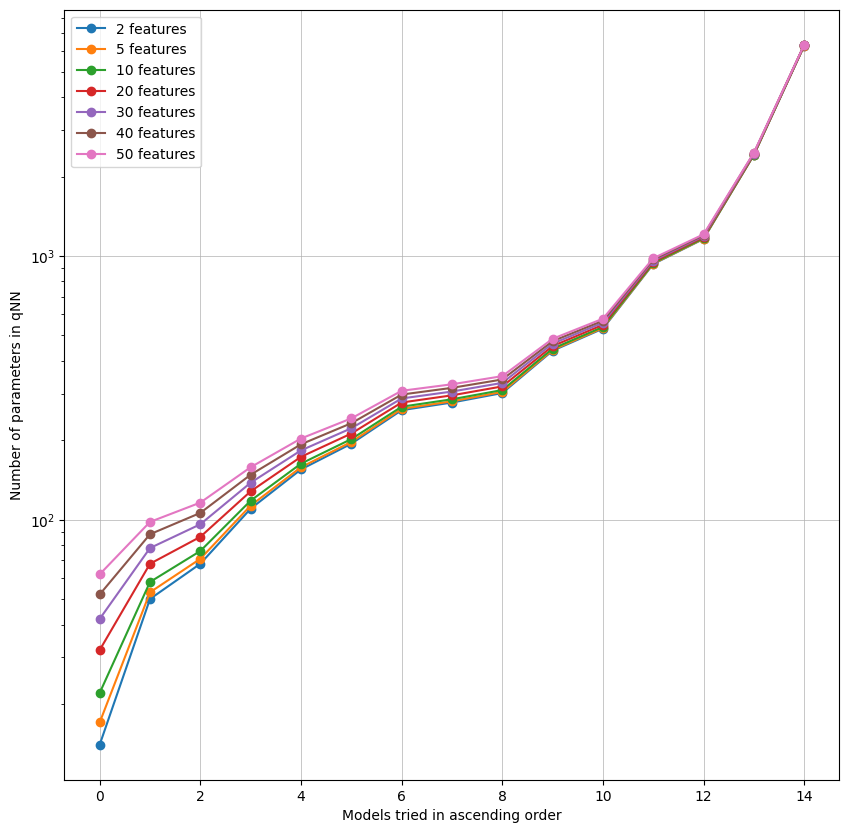

In [31]:
features_to_try = [2, 5, 10, 20, 30, 40,50]
dict_feat_numbers = {}

for feat in features_to_try:
    arch_with_params = sort_architecture(feat, NB_CLASSES)
    for i, (param_count, MODES, photons_count) in enumerate(arch_with_params):
        if str(feat) not in dict_feat_numbers.keys():
            dict_feat_numbers[str(feat)] = [param_count]
        else:
            dict_feat_numbers[str(feat)].append(param_count)

plt.figure(figsize=(10, 10))
for key in dict_feat_numbers.keys():
    plt.semilogy([k for k in range(len(dict_feat_numbers[key]))], dict_feat_numbers[key], label=f"{key} features", marker="o")
plt.xlabel('Models tried in ascending order')
plt.ylabel('Number of parameters in qNN')
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.legend()
plt.show()

In [32]:
# here, we want to scale the output for its encoding process in the HQNN
# here is a nn.Module that scales the output following different methods
class ScaleLayer(nn.Module):
    def __init__(self, dim, scale_type = "learned"):
        super(ScaleLayer, self).__init__()
        # Create a single learnable parameter (initialized to 1.0 by default)
        if scale_type == "learned":
            self.scale = nn.Parameter(torch.rand(dim))
        elif scale_type == "2pi":
            self.scale = torch.full((dim,), 2 * torch.pi)
        elif scale_type == "pi":
            self.scale = torch.full((dim,), torch.pi)
        elif scale_type == "1":
            self.scale = torch.full((dim,), 1)

    def forward(self, x):
        # Element-wise multiplication of each input element by the learned scale
        return x * self.scale

## 3. Now, we try them all for a given threshold and a given repetition time

In [33]:
# training loop
def train_qmodel(model, train_loader, val_loader, num_epochs = 25, lr=0.01):
    # train classical baseline
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = lr, betas=(0.8, 0.999))

    all_losses = []
    all_test_losses = []
    all_train_accuracies = []
    all_val_accuracies = []
    best_val_acc = 0
    progress_bar = tqdm(range(num_epochs))
    for epoch in progress_bar:
        model.train()
        total_loss = 0
        total_test_loss = 0
        correct = 0
        total = 0
        train_acc = 0
        for batch_X, batch_y in train_loader:
            # Forward pass
            # we divide the input data by pi to overpass the pi multiplication
            batch_X = batch_X.to(device)/torch.pi

            outputs = model(batch_X.squeeze(0).float())
            loss = criterion(outputs, batch_y.to(device)) #.view(-1, 1).float()
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

            # Update tqdm with current metrics
            current_accuracy = 100 * correct / total
            train_acc += current_accuracy
        model.eval()
        correct_test = 0
        total_test = 0
        val_acc = 0
        #for batch_X, batch_y in val_loader:
        for batch_X, batch_y in val_loader:
            # we divide the input data by pi to overpass the pi multiplication
            batch_X = batch_X.to(device)/torch.pi
            outputs = model(batch_X.squeeze(0).float())
            test_loss = criterion(outputs, batch_y.to(device)) #.view(-1, 1).float()
            total_test_loss += test_loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += batch_y.size(0)
            correct_test += (predicted == batch_y).sum().item()

            current_test_accuracy = 100 * correct_test / total_test
            val_acc += current_test_accuracy
        val_acc_epoch = val_acc / len(val_loader)
        train_acc_epoch = train_acc / len(train_loader)
        if val_acc_epoch > best_val_acc:
            best_val_acc = val_acc_epoch
        # Print progress
        avg_loss = total_loss / len(train_loader)
        avg_test_loss = total_test_loss / len(val_loader)

        all_losses.append(avg_loss)
        all_test_losses.append(avg_test_loss)
        all_train_accuracies.append(train_acc_epoch)
        all_val_accuracies.append(val_acc_epoch)
        progress_bar.set_postfix({
            "Test Loss": f"{avg_test_loss:.4f}",
            "Test Accuracy": f"{val_acc_epoch:.4f}",
        })
    """print(
            f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {avg_loss:.4f}, Test loss: {avg_test_loss:.4f}, Train acc: {current_accuracy:.4f}, Test acc: {current_test_accuracy:.4f}, Best val acc: {best_val_acc:.4f}')"""
    return all_losses, all_test_losses, best_val_acc, all_train_accuracies, all_val_accuracies


Now, time to train our HQNN !

In [34]:
THRESHOLD = 90
REPETITION = 5
LR = 0.05

features_to_try = [5,10,20,30,40,50] # do not hesitate to increase the number of parameters !

results_hqnn = {}
for NB_FEATURES in features_to_try:
    print(f"\n ---- NB_FEATURES: {NB_FEATURES} ----")
    above_thresh = False

    print(f"Ordering the models")
    arch_with_params = sort_architecture(NB_FEATURES, NB_CLASSES)
    print(f"Models ordered : time to go through them")

    for i, (param_count, MODES, photons_count) in enumerate(arch_with_params):
        if not above_thresh:
            all_accs = []

            for iter in range(REPETITION):
                print(f"Experiment {iter+1}/{REPETITION}")

                ### load data ###
                # load the data
                train_loader, val_loader = load_spiral(samples=NB_SAMPLES, features = NB_FEATURES)

                print(f"Building a Hybrid QNN with {MODES} modes, {photons_count} photons ({param_count} parameters)")

                # define input state
                input_state = [0]*MODES
                for k in range(photons_count):
                    input_state[2*k] = 1

                # we build the circuit
                circuit = create_quantum_circuit(MODES, size=NB_FEATURES)

                # from the circuit, we create a nn.Module
                boson_layer = ML.QuantumLayer(
                    input_size=NB_FEATURES,
                    output_size=NB_CLASSES,
                    circuit=circuit,
                    trainable_parameters=["ps", "bs"],
                    input_parameters=["px"],
                    input_state=input_state,
                    no_bunching = True,
                    output_mapping_strategy=ML.OutputMappingStrategy.LINEAR,
                )

                input_layer = ScaleLayer(NB_FEATURES, scale_type="learned")

                # model
                q_model = nn.Sequential(input_layer, boson_layer)


                ### TRAINING ###
                q_train_losses, q_val_losses, best_q_acc, q_train_accs, q_val_accs = train_qmodel(q_model, train_loader,
                                                                                                 val_loader,
                                                                                                 num_epochs=25,
                                                                                                 lr=LR)

                print(f" -  best ACC found = {best_q_acc}")
                #best_q_acc_thresh = best_q_acc
                all_accs.append(best_q_acc)

            mean_iter = np.mean(all_accs)
            std_iter = np.std(all_accs)

            if mean_iter > THRESHOLD:
                print(f"Convergence obtained for this dataset using {MODES} modes and {photons_count} photons.")
                above_thresh = True
                results_hqnn[f"{NB_FEATURES}"] = [sum(p.numel() for p in q_model.parameters() if p.requires_grad)]

            else:
                print(f"\n ----- No satisfying results found on {MODES} modes")
        else:
            break


 ---- NB_FEATURES: 5 ----
Ordering the models
Models ordered : time to go through them
Experiment 1/5
Building a Hybrid QNN with 2 modes, 1 photons (17 parameters)


100%|██████████| 25/25 [00:00<00:00, 44.00it/s, Test Loss=0.6481, Test Accuracy=56.6063]


 -  best ACC found = 63.5609375
Experiment 2/5
Building a Hybrid QNN with 2 modes, 1 photons (17 parameters)


100%|██████████| 25/25 [00:00<00:00, 45.53it/s, Test Loss=0.6425, Test Accuracy=67.4859]


 -  best ACC found = 68.8625
Experiment 3/5
Building a Hybrid QNN with 2 modes, 1 photons (17 parameters)


100%|██████████| 25/25 [00:00<00:00, 47.91it/s, Test Loss=0.6396, Test Accuracy=64.7724]


 -  best ACC found = 68.14166666666668
Experiment 4/5
Building a Hybrid QNN with 2 modes, 1 photons (17 parameters)


100%|██████████| 25/25 [00:00<00:00, 48.38it/s, Test Loss=0.6448, Test Accuracy=68.1859]


 -  best ACC found = 68.53229166666668
Experiment 5/5
Building a Hybrid QNN with 2 modes, 1 photons (17 parameters)


100%|██████████| 25/25 [00:00<00:00, 48.38it/s, Test Loss=0.9666, Test Accuracy=51.6208]


 -  best ACC found = 57.5734375

 ----- No satisfying results found on 2 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 1 photons (53 parameters)


100%|██████████| 25/25 [00:01<00:00, 14.26it/s, Test Loss=0.4483, Test Accuracy=78.3333]


 -  best ACC found = 87.034375
Experiment 2/5
Building a Hybrid QNN with 4 modes, 1 photons (53 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.46it/s, Test Loss=0.3783, Test Accuracy=82.9443]


 -  best ACC found = 89.1875
Experiment 3/5
Building a Hybrid QNN with 4 modes, 1 photons (53 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.17it/s, Test Loss=0.4478, Test Accuracy=80.2005]


 -  best ACC found = 80.30052083333334
Experiment 4/5
Building a Hybrid QNN with 4 modes, 1 photons (53 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.35it/s, Test Loss=0.4720, Test Accuracy=79.4307]


 -  best ACC found = 82.73958333333333
Experiment 5/5
Building a Hybrid QNN with 4 modes, 1 photons (53 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.30it/s, Test Loss=0.3269, Test Accuracy=81.0167]


 -  best ACC found = 86.99479166666667

 ----- No satisfying results found on 4 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 2 photons (71 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.76it/s, Test Loss=0.2447, Test Accuracy=90.6688]


 -  best ACC found = 95.83072916666667
Experiment 2/5
Building a Hybrid QNN with 4 modes, 2 photons (71 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.38it/s, Test Loss=0.2252, Test Accuracy=92.7615]


 -  best ACC found = 94.06822916666667
Experiment 3/5
Building a Hybrid QNN with 4 modes, 2 photons (71 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.68it/s, Test Loss=0.4224, Test Accuracy=78.9146]


 -  best ACC found = 88.9875
Experiment 4/5
Building a Hybrid QNN with 4 modes, 2 photons (71 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.92it/s, Test Loss=0.2791, Test Accuracy=87.8807]


 -  best ACC found = 91.80572916666668
Experiment 5/5
Building a Hybrid QNN with 4 modes, 2 photons (71 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.95it/s, Test Loss=0.3230, Test Accuracy=85.0068]


 -  best ACC found = 93.44270833333333
Convergence obtained for this dataset using 4 modes and 2 photons.

 ---- NB_FEATURES: 10 ----
Ordering the models
Models ordered : time to go through them
Experiment 1/5
Building a Hybrid QNN with 2 modes, 1 photons (22 parameters)


100%|██████████| 25/25 [00:00<00:00, 40.23it/s, Test Loss=0.6234, Test Accuracy=65.2885]


 -  best ACC found = 65.88385416666668
Experiment 2/5
Building a Hybrid QNN with 2 modes, 1 photons (22 parameters)


100%|██████████| 25/25 [00:00<00:00, 40.10it/s, Test Loss=0.6383, Test Accuracy=69.0531]


 -  best ACC found = 72.43177083333333
Experiment 3/5
Building a Hybrid QNN with 2 modes, 1 photons (22 parameters)


100%|██████████| 25/25 [00:00<00:00, 40.21it/s, Test Loss=0.6273, Test Accuracy=65.2375]


 -  best ACC found = 68.40208333333334
Experiment 4/5
Building a Hybrid QNN with 2 modes, 1 photons (22 parameters)


100%|██████████| 25/25 [00:00<00:00, 40.20it/s, Test Loss=0.6611, Test Accuracy=65.0375]


 -  best ACC found = 68.79270833333334
Experiment 5/5
Building a Hybrid QNN with 2 modes, 1 photons (22 parameters)


100%|██████████| 25/25 [00:00<00:00, 39.95it/s, Test Loss=0.6397, Test Accuracy=64.0167]


 -  best ACC found = 66.27916666666667

 ----- No satisfying results found on 2 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 1 photons (58 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.23it/s, Test Loss=0.4725, Test Accuracy=78.5635]


 -  best ACC found = 82.38854166666667
Experiment 2/5
Building a Hybrid QNN with 4 modes, 1 photons (58 parameters)


100%|██████████| 25/25 [00:01<00:00, 12.92it/s, Test Loss=0.3828, Test Accuracy=82.3536]


 -  best ACC found = 84.5765625
Experiment 3/5
Building a Hybrid QNN with 4 modes, 1 photons (58 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.09it/s, Test Loss=0.4396, Test Accuracy=79.7703]


 -  best ACC found = 85.1671875
Experiment 4/5
Building a Hybrid QNN with 4 modes, 1 photons (58 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.11it/s, Test Loss=0.4239, Test Accuracy=83.2745]


 -  best ACC found = 83.7
Experiment 5/5
Building a Hybrid QNN with 4 modes, 1 photons (58 parameters)


100%|██████████| 25/25 [00:01<00:00, 13.08it/s, Test Loss=0.3680, Test Accuracy=85.5484]


 -  best ACC found = 88.66666666666667

 ----- No satisfying results found on 4 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 2 photons (76 parameters)


100%|██████████| 25/25 [00:01<00:00, 12.94it/s, Test Loss=0.2125, Test Accuracy=90.5432]


 -  best ACC found = 92.47083333333333
Experiment 2/5
Building a Hybrid QNN with 4 modes, 2 photons (76 parameters)


100%|██████████| 25/25 [00:01<00:00, 12.91it/s, Test Loss=0.3280, Test Accuracy=89.3573]


 -  best ACC found = 89.35729166666667
Experiment 3/5
Building a Hybrid QNN with 4 modes, 2 photons (76 parameters)


100%|██████████| 25/25 [00:01<00:00, 12.81it/s, Test Loss=0.2712, Test Accuracy=90.8896]


 -  best ACC found = 96.19583333333333
Experiment 4/5
Building a Hybrid QNN with 4 modes, 2 photons (76 parameters)


100%|██████████| 25/25 [00:01<00:00, 12.82it/s, Test Loss=0.2997, Test Accuracy=84.9719]


 -  best ACC found = 89.32708333333332
Experiment 5/5
Building a Hybrid QNN with 4 modes, 2 photons (76 parameters)


100%|██████████| 25/25 [00:01<00:00, 12.87it/s, Test Loss=0.3070, Test Accuracy=85.4370]


 -  best ACC found = 90.14322916666667
Convergence obtained for this dataset using 4 modes and 2 photons.

 ---- NB_FEATURES: 20 ----
Ordering the models
Models ordered : time to go through them
Experiment 1/5
Building a Hybrid QNN with 2 modes, 1 photons (32 parameters)


100%|██████████| 25/25 [00:00<00:00, 30.28it/s, Test Loss=0.6245, Test Accuracy=67.4859]


 -  best ACC found = 72.296875
Experiment 2/5
Building a Hybrid QNN with 2 modes, 1 photons (32 parameters)


100%|██████████| 25/25 [00:00<00:00, 30.11it/s, Test Loss=0.6827, Test Accuracy=68.1974]


 -  best ACC found = 76.121875
Experiment 3/5
Building a Hybrid QNN with 2 modes, 1 photons (32 parameters)


100%|██████████| 25/25 [00:00<00:00, 27.71it/s, Test Loss=0.6627, Test Accuracy=75.1312]


 -  best ACC found = 75.13125
Experiment 4/5
Building a Hybrid QNN with 2 modes, 1 photons (32 parameters)


100%|██████████| 25/25 [00:00<00:00, 27.34it/s, Test Loss=0.6277, Test Accuracy=67.7766]


 -  best ACC found = 73.79427083333333
Experiment 5/5
Building a Hybrid QNN with 2 modes, 1 photons (32 parameters)


100%|██████████| 25/25 [00:00<00:00, 30.07it/s, Test Loss=0.6157, Test Accuracy=68.4068]


 -  best ACC found = 72.196875

 ----- No satisfying results found on 2 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 1 photons (68 parameters)


100%|██████████| 25/25 [00:02<00:00, 11.80it/s, Test Loss=0.4495, Test Accuracy=80.8120]


 -  best ACC found = 81.65833333333333
Experiment 2/5
Building a Hybrid QNN with 4 modes, 1 photons (68 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.87it/s, Test Loss=0.4194, Test Accuracy=87.3854]


 -  best ACC found = 88.9828125
Experiment 3/5
Building a Hybrid QNN with 4 modes, 1 photons (68 parameters)


100%|██████████| 25/25 [00:02<00:00, 11.26it/s, Test Loss=0.5536, Test Accuracy=75.2359]


 -  best ACC found = 81.74895833333332
Experiment 4/5
Building a Hybrid QNN with 4 modes, 1 photons (68 parameters)


100%|██████████| 25/25 [00:02<00:00, 11.24it/s, Test Loss=0.3514, Test Accuracy=86.8391]


 -  best ACC found = 88.92708333333333
Experiment 5/5
Building a Hybrid QNN with 4 modes, 1 photons (68 parameters)


100%|██████████| 25/25 [00:02<00:00, 11.60it/s, Test Loss=0.3603, Test Accuracy=87.5901]


 -  best ACC found = 88.86197916666667

 ----- No satisfying results found on 4 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 2 photons (86 parameters)


100%|██████████| 25/25 [00:02<00:00, 11.48it/s, Test Loss=0.2203, Test Accuracy=91.3547]


 -  best ACC found = 91.81041666666667
Experiment 2/5
Building a Hybrid QNN with 4 modes, 2 photons (86 parameters)


100%|██████████| 25/25 [00:02<00:00, 11.50it/s, Test Loss=0.2844, Test Accuracy=87.6552]


 -  best ACC found = 94.03802083333332
Experiment 3/5
Building a Hybrid QNN with 4 modes, 2 photons (86 parameters)


100%|██████████| 25/25 [00:02<00:00, 11.68it/s, Test Loss=0.3594, Test Accuracy=82.3885]


 -  best ACC found = 88.27604166666667
Experiment 4/5
Building a Hybrid QNN with 4 modes, 2 photons (86 parameters)


100%|██████████| 25/25 [00:02<00:00, 11.62it/s, Test Loss=0.3549, Test Accuracy=85.7672]


 -  best ACC found = 89.61770833333333
Experiment 5/5
Building a Hybrid QNN with 4 modes, 2 photons (86 parameters)


100%|██████████| 25/25 [00:02<00:00, 11.41it/s, Test Loss=0.2542, Test Accuracy=92.7219]


 -  best ACC found = 92.721875
Convergence obtained for this dataset using 4 modes and 2 photons.

 ---- NB_FEATURES: 30 ----
Ordering the models
Models ordered : time to go through them
Experiment 1/5
Building a Hybrid QNN with 2 modes, 1 photons (42 parameters)


100%|██████████| 25/25 [00:01<00:00, 24.19it/s, Test Loss=0.9917, Test Accuracy=49.1583]


 -  best ACC found = 58.81041666666667
Experiment 2/5
Building a Hybrid QNN with 2 modes, 1 photons (42 parameters)


100%|██████████| 25/25 [00:01<00:00, 24.17it/s, Test Loss=0.9090, Test Accuracy=51.1812]


 -  best ACC found = 55.852604166666666
Experiment 3/5
Building a Hybrid QNN with 2 modes, 1 photons (42 parameters)


100%|██████████| 25/25 [00:01<00:00, 24.09it/s, Test Loss=0.6629, Test Accuracy=55.1297]


 -  best ACC found = 67.2
Experiment 4/5
Building a Hybrid QNN with 2 modes, 1 photons (42 parameters)


100%|██████████| 25/25 [00:01<00:00, 23.92it/s, Test Loss=0.6513, Test Accuracy=58.3594]


 -  best ACC found = 68.63229166666667
Experiment 5/5
Building a Hybrid QNN with 2 modes, 1 photons (42 parameters)


100%|██████████| 25/25 [00:01<00:00, 24.10it/s, Test Loss=1.0066, Test Accuracy=47.1911]


 -  best ACC found = 60.04739583333334

 ----- No satisfying results found on 2 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 1 photons (78 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.45it/s, Test Loss=0.3847, Test Accuracy=78.9797]


 -  best ACC found = 90.32447916666666
Experiment 2/5
Building a Hybrid QNN with 4 modes, 1 photons (78 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.59it/s, Test Loss=0.3648, Test Accuracy=85.7578]


 -  best ACC found = 86.08333333333333
Experiment 3/5
Building a Hybrid QNN with 4 modes, 1 photons (78 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.67it/s, Test Loss=0.4327, Test Accuracy=80.6469]


 -  best ACC found = 85.03229166666668
Experiment 4/5
Building a Hybrid QNN with 4 modes, 1 photons (78 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.61it/s, Test Loss=0.3204, Test Accuracy=82.1583]


 -  best ACC found = 91.61041666666668
Experiment 5/5
Building a Hybrid QNN with 4 modes, 1 photons (78 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.54it/s, Test Loss=0.4346, Test Accuracy=76.4359]


 -  best ACC found = 83.04895833333333

 ----- No satisfying results found on 4 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 2 photons (96 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.56it/s, Test Loss=0.2895, Test Accuracy=88.0505]


 -  best ACC found = 93.86822916666668
Experiment 2/5
Building a Hybrid QNN with 4 modes, 2 photons (96 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.07it/s, Test Loss=0.3480, Test Accuracy=90.3990]


 -  best ACC found = 90.39895833333333
Experiment 3/5
Building a Hybrid QNN with 4 modes, 2 photons (96 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.22it/s, Test Loss=0.3137, Test Accuracy=88.4318]


 -  best ACC found = 91.3453125
Experiment 4/5
Building a Hybrid QNN with 4 modes, 2 photons (96 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.48it/s, Test Loss=0.3451, Test Accuracy=88.8922]


 -  best ACC found = 91.59635416666667
Experiment 5/5
Building a Hybrid QNN with 4 modes, 2 photons (96 parameters)


100%|██████████| 25/25 [00:02<00:00, 10.55it/s, Test Loss=0.4496, Test Accuracy=83.7604]


 -  best ACC found = 83.76041666666667
Convergence obtained for this dataset using 4 modes and 2 photons.

 ---- NB_FEATURES: 40 ----
Ordering the models
Models ordered : time to go through them
Experiment 1/5
Building a Hybrid QNN with 2 modes, 1 photons (52 parameters)


100%|██████████| 25/25 [00:01<00:00, 19.96it/s, Test Loss=0.6404, Test Accuracy=59.1057]


 -  best ACC found = 65.46302083333333
Experiment 2/5
Building a Hybrid QNN with 2 modes, 1 photons (52 parameters)


100%|██████████| 25/25 [00:01<00:00, 19.95it/s, Test Loss=1.0456, Test Accuracy=46.1354]


 -  best ACC found = 53.625
Experiment 3/5
Building a Hybrid QNN with 2 modes, 1 photons (52 parameters)


100%|██████████| 25/25 [00:01<00:00, 19.94it/s, Test Loss=0.6556, Test Accuracy=62.6005]


 -  best ACC found = 64.08177083333334
Experiment 4/5
Building a Hybrid QNN with 2 modes, 1 photons (52 parameters)


100%|██████████| 25/25 [00:01<00:00, 19.92it/s, Test Loss=0.6859, Test Accuracy=63.8516]


 -  best ACC found = 64.746875
Experiment 5/5
Building a Hybrid QNN with 2 modes, 1 photons (52 parameters)


100%|██████████| 25/25 [00:01<00:00, 19.32it/s, Test Loss=0.6614, Test Accuracy=62.8099]


 -  best ACC found = 65.07708333333332

 ----- No satisfying results found on 2 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 1 photons (88 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.68it/s, Test Loss=0.4756, Test Accuracy=80.0099]


 -  best ACC found = 80.62135416666666
Experiment 2/5
Building a Hybrid QNN with 4 modes, 1 photons (88 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.74it/s, Test Loss=0.4396, Test Accuracy=81.2375]


 -  best ACC found = 81.2375
Experiment 3/5
Building a Hybrid QNN with 4 modes, 1 photons (88 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.21it/s, Test Loss=0.5437, Test Accuracy=72.0156]


 -  best ACC found = 84.51614583333333
Experiment 4/5
Building a Hybrid QNN with 4 modes, 1 photons (88 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.50it/s, Test Loss=0.3632, Test Accuracy=84.8115]


 -  best ACC found = 84.81145833333332
Experiment 5/5
Building a Hybrid QNN with 4 modes, 1 photons (88 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.49it/s, Test Loss=0.3668, Test Accuracy=83.7604]


 -  best ACC found = 86.90416666666667

 ----- No satisfying results found on 4 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 2 photons (106 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.60it/s, Test Loss=0.3222, Test Accuracy=88.5016]


 -  best ACC found = 91.8359375
Experiment 2/5
Building a Hybrid QNN with 4 modes, 2 photons (106 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.68it/s, Test Loss=0.2923, Test Accuracy=90.2339]


 -  best ACC found = 90.23385416666667
Experiment 3/5
Building a Hybrid QNN with 4 modes, 2 photons (106 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.73it/s, Test Loss=0.6059, Test Accuracy=74.9453]


 -  best ACC found = 76.86354166666666
Experiment 4/5
Building a Hybrid QNN with 4 modes, 2 photons (106 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.33it/s, Test Loss=0.5811, Test Accuracy=75.6104]


 -  best ACC found = 92.17083333333332
Experiment 5/5
Building a Hybrid QNN with 4 modes, 2 photons (106 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.44it/s, Test Loss=0.5651, Test Accuracy=79.1005]


 -  best ACC found = 82.66041666666666

 ----- No satisfying results found on 4 modes
Experiment 1/5
Building a Hybrid QNN with 6 modes, 1 photons (148 parameters)


100%|██████████| 25/25 [00:05<00:00,  5.00it/s, Test Loss=0.4568, Test Accuracy=83.5255]


 -  best ACC found = 84.090625
Experiment 2/5
Building a Hybrid QNN with 6 modes, 1 photons (148 parameters)


100%|██████████| 25/25 [00:04<00:00,  5.03it/s, Test Loss=0.3998, Test Accuracy=84.1906]


 -  best ACC found = 87.19947916666666
Experiment 3/5
Building a Hybrid QNN with 6 modes, 1 photons (148 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.98it/s, Test Loss=0.3425, Test Accuracy=83.6604]


 -  best ACC found = 89.7734375
Experiment 4/5
Building a Hybrid QNN with 6 modes, 1 photons (148 parameters)


100%|██████████| 25/25 [00:04<00:00,  5.04it/s, Test Loss=0.4848, Test Accuracy=78.1031]


 -  best ACC found = 84.14635416666667
Experiment 5/5
Building a Hybrid QNN with 6 modes, 1 photons (148 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.94it/s, Test Loss=0.4067, Test Accuracy=75.4781]


 -  best ACC found = 81.41197916666667

 ----- No satisfying results found on 6 modes
Experiment 1/5
Building a Hybrid QNN with 6 modes, 2 photons (193 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.94it/s, Test Loss=0.3068, Test Accuracy=88.9224]


 -  best ACC found = 92.63125
Experiment 2/5
Building a Hybrid QNN with 6 modes, 2 photons (193 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.98it/s, Test Loss=0.3630, Test Accuracy=85.7578]


 -  best ACC found = 86.31354166666668
Experiment 3/5
Building a Hybrid QNN with 6 modes, 2 photons (193 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.95it/s, Test Loss=0.3338, Test Accuracy=90.2385]


 -  best ACC found = 91.35
Experiment 4/5
Building a Hybrid QNN with 6 modes, 2 photons (193 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.95it/s, Test Loss=0.2818, Test Accuracy=88.7365]


 -  best ACC found = 95.14010416666667
Experiment 5/5
Building a Hybrid QNN with 6 modes, 2 photons (193 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.92it/s, Test Loss=0.3141, Test Accuracy=89.0526]


 -  best ACC found = 93.021875
Convergence obtained for this dataset using 6 modes and 2 photons.

 ---- NB_FEATURES: 50 ----
Ordering the models
Models ordered : time to go through them
Experiment 1/5
Building a Hybrid QNN with 2 modes, 1 photons (62 parameters)


100%|██████████| 25/25 [00:01<00:00, 16.76it/s, Test Loss=0.9295, Test Accuracy=58.2292]


 -  best ACC found = 59.8078125
Experiment 2/5
Building a Hybrid QNN with 2 modes, 1 photons (62 parameters)


100%|██████████| 25/25 [00:01<00:00, 16.75it/s, Test Loss=1.0409, Test Accuracy=43.7172]


 -  best ACC found = 46.746875
Experiment 3/5
Building a Hybrid QNN with 2 modes, 1 photons (62 parameters)


100%|██████████| 25/25 [00:01<00:00, 16.45it/s, Test Loss=1.0200, Test Accuracy=46.9958]


 -  best ACC found = 51.532291666666666
Experiment 4/5
Building a Hybrid QNN with 2 modes, 1 photons (62 parameters)


100%|██████████| 25/25 [00:01<00:00, 17.37it/s, Test Loss=1.0516, Test Accuracy=48.8792]


 -  best ACC found = 51.10208333333334
Experiment 5/5
Building a Hybrid QNN with 2 modes, 1 photons (62 parameters)


100%|██████████| 25/25 [00:01<00:00, 17.14it/s, Test Loss=0.8012, Test Accuracy=64.2422]


 -  best ACC found = 64.2421875

 ----- No satisfying results found on 2 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 1 photons (98 parameters)


100%|██████████| 25/25 [00:02<00:00,  8.65it/s, Test Loss=0.5214, Test Accuracy=75.7755]


 -  best ACC found = 79.80052083333334
Experiment 2/5
Building a Hybrid QNN with 4 modes, 1 photons (98 parameters)


100%|██████████| 25/25 [00:02<00:00,  8.98it/s, Test Loss=0.4989, Test Accuracy=79.4052]


 -  best ACC found = 81.59322916666667
Experiment 3/5
Building a Hybrid QNN with 4 modes, 1 photons (98 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.09it/s, Test Loss=0.5734, Test Accuracy=73.1969]


 -  best ACC found = 75.50572916666667
Experiment 4/5
Building a Hybrid QNN with 4 modes, 1 photons (98 parameters)


100%|██████████| 25/25 [00:03<00:00,  8.10it/s, Test Loss=0.5801, Test Accuracy=77.3427]


 -  best ACC found = 79.14010416666667
Experiment 5/5
Building a Hybrid QNN with 4 modes, 1 photons (98 parameters)


100%|██████████| 25/25 [00:02<00:00,  8.57it/s, Test Loss=0.5764, Test Accuracy=72.8875]


 -  best ACC found = 77.33802083333333

 ----- No satisfying results found on 4 modes
Experiment 1/5
Building a Hybrid QNN with 4 modes, 2 photons (116 parameters)


100%|██████████| 25/25 [00:02<00:00,  8.51it/s, Test Loss=0.4503, Test Accuracy=77.7682]


 -  best ACC found = 85.32291666666667
Experiment 2/5
Building a Hybrid QNN with 4 modes, 2 photons (116 parameters)


100%|██████████| 25/25 [00:02<00:00,  8.81it/s, Test Loss=0.4554, Test Accuracy=80.3516]


 -  best ACC found = 87.9015625
Experiment 3/5
Building a Hybrid QNN with 4 modes, 2 photons (116 parameters)


100%|██████████| 25/25 [00:02<00:00,  8.86it/s, Test Loss=0.4102, Test Accuracy=82.9188]


 -  best ACC found = 85.72760416666668
Experiment 4/5
Building a Hybrid QNN with 4 modes, 2 photons (116 parameters)


100%|██████████| 25/25 [00:02<00:00,  9.02it/s, Test Loss=0.5144, Test Accuracy=79.2656]


 -  best ACC found = 79.3609375
Experiment 5/5
Building a Hybrid QNN with 4 modes, 2 photons (116 parameters)


100%|██████████| 25/25 [00:02<00:00,  8.97it/s, Test Loss=0.3389, Test Accuracy=83.6302]


 -  best ACC found = 89.83854166666667

 ----- No satisfying results found on 4 modes
Experiment 1/5
Building a Hybrid QNN with 6 modes, 1 photons (158 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.82it/s, Test Loss=0.4331, Test Accuracy=80.6167]


 -  best ACC found = 87.94114583333334
Experiment 2/5
Building a Hybrid QNN with 6 modes, 1 photons (158 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.82it/s, Test Loss=0.4510, Test Accuracy=81.1167]


 -  best ACC found = 86.76927083333334
Experiment 3/5
Building a Hybrid QNN with 6 modes, 1 photons (158 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.80it/s, Test Loss=0.5322, Test Accuracy=72.3365]


 -  best ACC found = 84.15104166666667
Experiment 4/5
Building a Hybrid QNN with 6 modes, 1 photons (158 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.77it/s, Test Loss=0.3430, Test Accuracy=85.1464]


 -  best ACC found = 89.05729166666667
Experiment 5/5
Building a Hybrid QNN with 6 modes, 1 photons (158 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.60it/s, Test Loss=0.3755, Test Accuracy=86.5135]


 -  best ACC found = 87.58541666666667

 ----- No satisfying results found on 6 modes
Experiment 1/5
Building a Hybrid QNN with 6 modes, 2 photons (203 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Test Loss=0.4040, Test Accuracy=83.9161]


 -  best ACC found = 85.78802083333332
Experiment 2/5
Building a Hybrid QNN with 6 modes, 2 photons (203 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.61it/s, Test Loss=0.4030, Test Accuracy=84.7161]


 -  best ACC found = 87.49010416666667
Experiment 3/5
Building a Hybrid QNN with 6 modes, 2 photons (203 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.79it/s, Test Loss=0.2688, Test Accuracy=91.4198]


 -  best ACC found = 91.41979166666667
Experiment 4/5
Building a Hybrid QNN with 6 modes, 2 photons (203 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Test Loss=0.4443, Test Accuracy=83.4255]


 -  best ACC found = 85.52760416666666
Experiment 5/5
Building a Hybrid QNN with 6 modes, 2 photons (203 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.63it/s, Test Loss=0.4241, Test Accuracy=80.0469]


 -  best ACC found = 82.309375

 ----- No satisfying results found on 6 modes
Experiment 1/5
Building a Hybrid QNN with 8 modes, 1 photons (242 parameters)


100%|██████████| 25/25 [00:09<00:00,  2.73it/s, Test Loss=0.4120, Test Accuracy=88.2318]


 -  best ACC found = 88.23177083333333
Experiment 2/5
Building a Hybrid QNN with 8 modes, 1 photons (242 parameters)


100%|██████████| 25/25 [00:09<00:00,  2.70it/s, Test Loss=0.4939, Test Accuracy=78.0333]


 -  best ACC found = 81.59322916666667
Experiment 3/5
Building a Hybrid QNN with 8 modes, 1 photons (242 parameters)


100%|██████████| 25/25 [00:09<00:00,  2.72it/s, Test Loss=0.4627, Test Accuracy=78.7542]


 -  best ACC found = 82.86510416666667
Experiment 4/5
Building a Hybrid QNN with 8 modes, 1 photons (242 parameters)


100%|██████████| 25/25 [00:09<00:00,  2.74it/s, Test Loss=0.4689, Test Accuracy=82.4792]


 -  best ACC found = 83.32552083333333
Experiment 5/5
Building a Hybrid QNN with 8 modes, 1 photons (242 parameters)


100%|██████████| 25/25 [00:09<00:00,  2.71it/s, Test Loss=0.3758, Test Accuracy=83.1141]


 -  best ACC found = 87.715625

 ----- No satisfying results found on 8 modes
Experiment 1/5
Building a Hybrid QNN with 6 modes, 3 photons (308 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Test Loss=0.3472, Test Accuracy=86.5693]


 -  best ACC found = 88.63177083333332
Experiment 2/5
Building a Hybrid QNN with 6 modes, 3 photons (308 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.70it/s, Test Loss=0.3285, Test Accuracy=88.5062]


 -  best ACC found = 90.7640625
Experiment 3/5
Building a Hybrid QNN with 6 modes, 3 photons (308 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.76it/s, Test Loss=0.4213, Test Accuracy=87.3552]


 -  best ACC found = 87.35520833333334
Experiment 4/5
Building a Hybrid QNN with 6 modes, 3 photons (308 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.74it/s, Test Loss=0.3640, Test Accuracy=83.5604]


 -  best ACC found = 91.68020833333333
Experiment 5/5
Building a Hybrid QNN with 6 modes, 3 photons (308 parameters)


100%|██████████| 25/25 [00:05<00:00,  4.65it/s, Test Loss=0.3216, Test Accuracy=92.1661]

 -  best ACC found = 92.16614583333333
Convergence obtained for this dataset using 6 modes and 3 photons.


## 4. Now, let's compare with a classical MLP !

In [13]:
# first, we need to be able to create a MLP based on its parameter count
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int], output_dim: int):
        super(MLP, self).__init__()

        layers = []
        prev_dim = input_dim

        # Hidden layers
        if type(hidden_dims) == int:
            layers.append(nn.Linear(input_dim, output_dim))
        else:
            for hidden_dim in hidden_dims:
                layers.append(nn.Linear(prev_dim, hidden_dim))
                layers.append(nn.ReLU())
                prev_dim = hidden_dim

            # Output layer
            layers.append(nn.Linear(prev_dim, output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def generate_architectures_mlp():
    """Generate different MLP architectures varying depth and width"""
    architectures = []
    architectures.append((1,1))
    # Hidden dimensions to try
    hidden_dims = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
    for num_layers in range(2, 6):  # 2, 3, 4,5 layers
        for base_dim in hidden_dims:
            if num_layers == 2:
                # 2 layers: [hidden, output]
                arch = [base_dim]
            elif num_layers == 3:
                # 3 layers: [hidden1, hidden2, output]
                arch = [base_dim, base_dim // 2]
            else:  # num_layers == 4
                # 4 layers: [hidden1, hidden2, hidden3, output]
                arch = [base_dim, base_dim // 2, base_dim // 4]

            architectures.append((num_layers, arch))

    return architectures

Now, we can observe the number of parameters in these MLP with respect to the number of features : we are going to test these models on our data, starting by the smallest one:

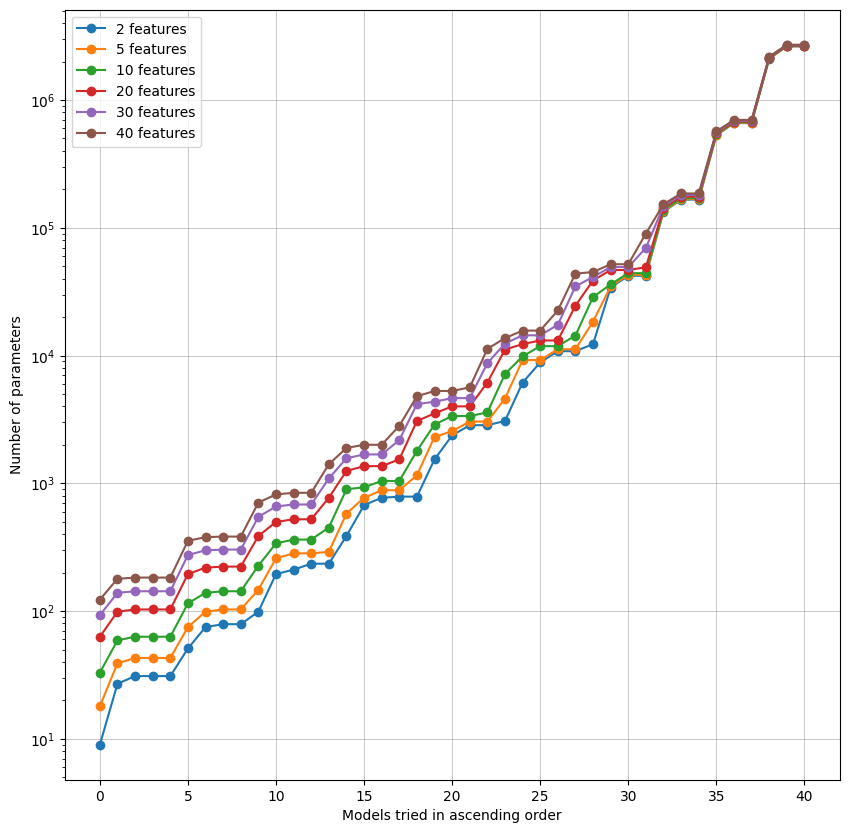

In [14]:
features_to_try = [2,5,10,20,30,40]
# get all architectures
architectures = generate_architectures_mlp()
dict_feat_numbers = {}
# sort them by number of parameters wrt to number of features
for feat in features_to_try:
    arch_with_params = []
    for num_layers, hidden_dims in architectures:
        temp_model = MLP(feat, hidden_dims, 3)
        param_count = temp_model.count_parameters()
        arch_with_params.append((param_count, num_layers, hidden_dims))
    # Sort by parameter count (smallest to largest)
    arch_with_params.sort(key=lambda x: x[0])
    for i, (param_count, num_layers, hidden_dims) in enumerate(arch_with_params):
        model = MLP(feat, hidden_dims, 3)
        if str(feat) not in dict_feat_numbers.keys():
            dict_feat_numbers[str(feat)] = [param_count]
        else:
            dict_feat_numbers[str(feat)].append(param_count)

# plot the figure
plt.figure(figsize=(10, 10))
for key in dict_feat_numbers.keys():
    plt.semilogy([k for k in range(len(dict_feat_numbers[key]))], dict_feat_numbers[key], label=f"{key} features", marker="o")
plt.xlabel('Models tried in ascending order')
plt.ylabel('Number of parameters')
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.legend()
plt.show()

Now, time to train our MLP !

In [36]:
# training loop
def train_cl_model(model, train_loader, val_loader, num_epochs = 25, lr=0.01):
    # train classical baseline
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = lr, betas=(0.8, 0.999))

    all_losses = []
    all_test_losses = []
    all_train_accuracies = []
    all_val_accuracies = []
    best_val_acc = 0
    progress_bar = tqdm(range(num_epochs))
    for epoch in progress_bar:
        model.train()
        total_loss = 0
        total_test_loss = 0
        correct = 0
        total = 0
        train_acc = 0
        for batch_X, batch_y in train_loader:
            # Forward pass
            batch_X = batch_X.to(device)

            outputs = model(batch_X.squeeze(0).float())
            loss = criterion(outputs, batch_y.to(device)) #.view(-1, 1).float()
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

            # Update tqdm with current metrics
            current_accuracy = 100 * correct / total
            train_acc += current_accuracy
        model.eval()
        correct_test = 0
        total_test = 0
        val_acc = 0
        #for batch_X, batch_y in val_loader:
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X.squeeze(0).float())
            test_loss = criterion(outputs, batch_y.to(device)) #.view(-1, 1).float()
            total_test_loss += test_loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += batch_y.size(0)
            correct_test += (predicted == batch_y).sum().item()

            current_test_accuracy = 100 * correct_test / total_test
            val_acc += current_test_accuracy
        val_acc_epoch = val_acc / len(val_loader)
        train_acc_epoch = train_acc / len(train_loader)
        if val_acc_epoch > best_val_acc:
            best_val_acc = val_acc_epoch
        # Print progress
        avg_loss = total_loss / len(train_loader)
        avg_test_loss = total_test_loss / len(val_loader)

        all_losses.append(avg_loss)
        all_test_losses.append(avg_test_loss)
        all_train_accuracies.append(train_acc_epoch)
        all_val_accuracies.append(val_acc_epoch)
        progress_bar.set_postfix({
            "Test Loss": f"{avg_test_loss:.4f}",
            "Test Accuracy": f"{val_acc_epoch:.4f}",
        })
    """print(
            f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {avg_loss:.4f}, Test loss: {avg_test_loss:.4f}, Train acc: {current_accuracy:.4f}, Test acc: {current_test_accuracy:.4f}, Best val acc: {best_val_acc:.4f}')"""
    return all_losses, all_test_losses, best_val_acc, all_train_accuracies, all_val_accuracies

In [37]:
# here are the same parameters as before
THRESHOLD = 90
REPETITION = 5

LR = 0.01

features_to_try = [5,10,20,30,40,50] # do not hesitate to increase the number of parameters !

results_mlp = {}

for NB_FEATURES in features_to_try:
    print(f"\n ---> Experimenting using {NB_FEATURES} features")

    above_thresh = False
    print("\n ---- generating and sorting the models by number of parameters ----")
    architectures = generate_architectures_mlp()
    print("\n ---- models sorted ----")
    arch_with_params = []
    for num_layers, hidden_dims in architectures:
        temp_model = MLP(NB_FEATURES, hidden_dims, NB_CLASSES)
        param_count = temp_model.count_parameters()
        arch_with_params.append((param_count, num_layers, hidden_dims))

    # Sort by parameter count (smallest to largest)
    arch_with_params.sort(key=lambda x: x[0])

    for i, (param_count, num_layers, hidden_dims) in enumerate(arch_with_params):
        if not above_thresh:
            all_accs = []
            for iter in range(REPETITION):
                print()
                # Create model
                print(f"Experiment {iter+1}/{REPETITION}")

                ### load data ###
                # load the data
                train_loader, val_loader = load_spiral(samples=NB_SAMPLES, features = NB_FEATURES)

                print(f"Building a MLP with {param_count} parameters")
                model = MLP(NB_FEATURES, hidden_dims, NB_CLASSES)
                print(f"\n Model built")
                cl_train_losses, cl_val_losses, best_cl_acc, cl_train_accs, cl_val_accs = train_cl_model(model,
                                                                                                      train_loader,
                                                                                                      val_loader,
                                                                                                    num_epochs=25,
                                                                                                      lr=LR)
                all_accs.append(best_cl_acc)


            mean_iter = np.mean(all_accs)
            std_iter = np.std(all_accs)
            if mean_iter >= THRESHOLD:
                above_thresh = True
                print(f"\n Threshold achieved: {mean_iter} +- {std_iter} using {param_count} parameters")
                results_mlp[f"{NB_FEATURES}"] = [sum(p.numel() for p in model.parameters() if p.requires_grad)]
            else:
                print(f"{mean_iter} < {THRESHOLD} therefore moving on with next model")
        else:
            break


 ---> Experimenting using 5 features

 ---- generating and sorting the models by number of parameters ----

 ---- models sorted ----

Experiment 1/5
Building a MLP with 18 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 194.92it/s, Test Loss=0.4661, Test Accuracy=73.3271]



Experiment 2/5
Building a MLP with 18 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 194.05it/s, Test Loss=0.4536, Test Accuracy=76.3359]



Experiment 3/5
Building a MLP with 18 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 207.24it/s, Test Loss=0.4584, Test Accuracy=74.2432]



Experiment 4/5
Building a MLP with 18 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 193.34it/s, Test Loss=0.4618, Test Accuracy=75.8151]



Experiment 5/5
Building a MLP with 18 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 215.09it/s, Test Loss=0.4632, Test Accuracy=74.6688]


75.25145833333333 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 39 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 192.52it/s, Test Loss=0.3282, Test Accuracy=90.4083]



Experiment 2/5
Building a MLP with 39 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 172.39it/s, Test Loss=0.3894, Test Accuracy=83.8953]



Experiment 3/5
Building a MLP with 39 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 160.59it/s, Test Loss=0.3075, Test Accuracy=83.6000]



Experiment 4/5
Building a MLP with 39 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 164.86it/s, Test Loss=0.3473, Test Accuracy=88.4156]



Experiment 5/5
Building a MLP with 39 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 176.09it/s, Test Loss=0.3543, Test Accuracy=88.5760]


88.00354166666666 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 149.38it/s, Test Loss=0.2258, Test Accuracy=91.7802]



Experiment 2/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 154.46it/s, Test Loss=0.3831, Test Accuracy=83.4349]



Experiment 3/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 170.40it/s, Test Loss=0.2236, Test Accuracy=94.2333]



Experiment 4/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 168.97it/s, Test Loss=0.5798, Test Accuracy=63.5307]



Experiment 5/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 178.31it/s, Test Loss=0.1932, Test Accuracy=95.4448]


85.8921875 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 163.54it/s, Test Loss=1.0993, Test Accuracy=34.3323]



Experiment 2/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 160.02it/s, Test Loss=0.3508, Test Accuracy=92.6964]



Experiment 3/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 126.13it/s, Test Loss=1.0992, Test Accuracy=34.3323]



Experiment 4/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 152.97it/s, Test Loss=1.0993, Test Accuracy=34.3323]



Experiment 5/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 150.88it/s, Test Loss=0.5559, Test Accuracy=74.5083]


54.511874999999996 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 165.30it/s, Test Loss=1.0989, Test Accuracy=34.3323]



Experiment 2/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 164.68it/s, Test Loss=1.0996, Test Accuracy=34.3323]



Experiment 3/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 165.70it/s, Test Loss=0.5674, Test Accuracy=74.0828]



Experiment 4/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 161.55it/s, Test Loss=1.0992, Test Accuracy=34.3323]



Experiment 5/5
Building a MLP with 43 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 165.99it/s, Test Loss=0.4958, Test Accuracy=77.2964]


52.053645833333334 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 75 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 194.96it/s, Test Loss=0.1762, Test Accuracy=95.3495]



Experiment 2/5
Building a MLP with 75 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 115.74it/s, Test Loss=0.1632, Test Accuracy=94.9240]



Experiment 3/5
Building a MLP with 75 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 158.54it/s, Test Loss=0.1795, Test Accuracy=95.7750]



Experiment 4/5
Building a MLP with 75 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 175.39it/s, Test Loss=0.1612, Test Accuracy=94.5333]



Experiment 5/5
Building a MLP with 75 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 158.93it/s, Test Loss=0.1400, Test Accuracy=95.3495]



 Threshold achieved: 95.51270833333334 +- 0.4230865576251009 using 75 parameters

 ---> Experimenting using 10 features

 ---- generating and sorting the models by number of parameters ----

 ---- models sorted ----

Experiment 1/5
Building a MLP with 33 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 181.58it/s, Test Loss=0.3953, Test Accuracy=79.5448]



Experiment 2/5
Building a MLP with 33 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 194.95it/s, Test Loss=0.3996, Test Accuracy=78.8589]



Experiment 3/5
Building a MLP with 33 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 199.48it/s, Test Loss=0.3976, Test Accuracy=79.6052]



Experiment 4/5
Building a MLP with 33 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 195.81it/s, Test Loss=0.3944, Test Accuracy=79.8703]



Experiment 5/5
Building a MLP with 33 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 213.24it/s, Test Loss=0.4033, Test Accuracy=79.7750]


79.56479166666668 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 59 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 193.87it/s, Test Loss=0.3199, Test Accuracy=90.4594]



Experiment 2/5
Building a MLP with 59 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 194.34it/s, Test Loss=0.3022, Test Accuracy=89.4526]



Experiment 3/5
Building a MLP with 59 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 182.92it/s, Test Loss=0.3136, Test Accuracy=86.7391]



Experiment 4/5
Building a MLP with 59 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 179.96it/s, Test Loss=0.3163, Test Accuracy=94.8495]



Experiment 5/5
Building a MLP with 59 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 176.23it/s, Test Loss=0.2153, Test Accuracy=94.4286]



 Threshold achieved: 91.27093750000002 +- 3.1782542138869667 using 59 parameters

 ---> Experimenting using 20 features

 ---- generating and sorting the models by number of parameters ----

 ---- models sorted ----

Experiment 1/5
Building a MLP with 63 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 196.16it/s, Test Loss=0.4063, Test Accuracy=78.5589]



Experiment 2/5
Building a MLP with 63 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 196.50it/s, Test Loss=0.4083, Test Accuracy=77.5125]



Experiment 3/5
Building a MLP with 63 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 213.92it/s, Test Loss=0.4104, Test Accuracy=77.9380]



Experiment 4/5
Building a MLP with 63 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 215.59it/s, Test Loss=0.4059, Test Accuracy=78.7891]



Experiment 5/5
Building a MLP with 63 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 207.69it/s, Test Loss=0.4076, Test Accuracy=76.9266]


78.59187499999999 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 99 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 192.96it/s, Test Loss=0.2362, Test Accuracy=92.9870]



Experiment 2/5
Building a MLP with 99 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 192.49it/s, Test Loss=0.3470, Test Accuracy=86.3089]



Experiment 3/5
Building a MLP with 99 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 178.28it/s, Test Loss=0.2972, Test Accuracy=92.9870]



Experiment 4/5
Building a MLP with 99 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 164.58it/s, Test Loss=0.2816, Test Accuracy=89.6781]



Experiment 5/5
Building a MLP with 99 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 184.67it/s, Test Loss=0.2798, Test Accuracy=90.3688]



 Threshold achieved: 91.0728125 +- 2.6340153430185156 using 99 parameters

 ---> Experimenting using 30 features

 ---- generating and sorting the models by number of parameters ----

 ---- models sorted ----

Experiment 1/5
Building a MLP with 93 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 203.11it/s, Test Loss=0.3982, Test Accuracy=82.2188]



Experiment 2/5
Building a MLP with 93 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 195.89it/s, Test Loss=0.3979, Test Accuracy=80.4818]



Experiment 3/5
Building a MLP with 93 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 197.29it/s, Test Loss=0.3996, Test Accuracy=80.2865]



Experiment 4/5
Building a MLP with 93 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 194.08it/s, Test Loss=0.3978, Test Accuracy=81.9885]



Experiment 5/5
Building a MLP with 93 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 185.67it/s, Test Loss=0.3958, Test Accuracy=81.1375]


81.78020833333332 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 139 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 162.70it/s, Test Loss=0.3508, Test Accuracy=80.2354]



Experiment 2/5
Building a MLP with 139 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 162.53it/s, Test Loss=0.2845, Test Accuracy=91.4547]



Experiment 3/5
Building a MLP with 139 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 162.61it/s, Test Loss=0.2919, Test Accuracy=88.7365]



Experiment 4/5
Building a MLP with 139 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 164.51it/s, Test Loss=0.3044, Test Accuracy=93.9333]



Experiment 5/5
Building a MLP with 139 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 158.57it/s, Test Loss=0.3460, Test Accuracy=86.3042]


89.13822916666666 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 153.89it/s, Test Loss=0.3928, Test Accuracy=89.5734]



Experiment 2/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 144.82it/s, Test Loss=0.4697, Test Accuracy=81.3375]



Experiment 3/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 143.83it/s, Test Loss=0.5080, Test Accuracy=79.2401]



Experiment 4/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 165.36it/s, Test Loss=0.2529, Test Accuracy=93.4078]



Experiment 5/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 162.65it/s, Test Loss=0.3737, Test Accuracy=86.5901]


87.808125 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 139.67it/s, Test Loss=0.6609, Test Accuracy=61.4542]



Experiment 2/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 147.41it/s, Test Loss=1.0990, Test Accuracy=34.3323]



Experiment 3/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 148.08it/s, Test Loss=0.4992, Test Accuracy=80.9120]



Experiment 4/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 151.87it/s, Test Loss=1.0989, Test Accuracy=34.3323]



Experiment 5/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 143.31it/s, Test Loss=0.4566, Test Accuracy=87.8458]


60.208749999999995 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 142.13it/s, Test Loss=0.5301, Test Accuracy=84.3115]



Experiment 2/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 123.78it/s, Test Loss=1.0990, Test Accuracy=34.3323]



Experiment 3/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 131.83it/s, Test Loss=1.0992, Test Accuracy=34.3323]



Experiment 4/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 139.77it/s, Test Loss=1.0994, Test Accuracy=34.3323]



Experiment 5/5
Building a MLP with 143 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 132.86it/s, Test Loss=0.7953, Test Accuracy=58.9802]


50.28406249999999 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 275 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 158.10it/s, Test Loss=0.2506, Test Accuracy=92.6964]



Experiment 2/5
Building a MLP with 275 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 180.93it/s, Test Loss=0.2018, Test Accuracy=95.2146]



Experiment 3/5
Building a MLP with 275 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 153.92it/s, Test Loss=0.2609, Test Accuracy=92.4661]



Experiment 4/5
Building a MLP with 275 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 177.36it/s, Test Loss=0.2663, Test Accuracy=92.8568]



Experiment 5/5
Building a MLP with 275 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 181.70it/s, Test Loss=0.2469, Test Accuracy=94.4589]



 Threshold achieved: 93.89895833333334 +- 1.06976336785031 using 275 parameters

 ---> Experimenting using 40 features

 ---- generating and sorting the models by number of parameters ----

 ---- models sorted ----

Experiment 1/5
Building a MLP with 123 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 190.04it/s, Test Loss=0.4151, Test Accuracy=77.0521]



Experiment 2/5
Building a MLP with 123 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 201.83it/s, Test Loss=0.4157, Test Accuracy=77.8682]



Experiment 3/5
Building a MLP with 123 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 202.64it/s, Test Loss=0.4145, Test Accuracy=78.1984]



Experiment 4/5
Building a MLP with 123 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 204.63it/s, Test Loss=0.4157, Test Accuracy=77.3823]



Experiment 5/5
Building a MLP with 123 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 195.37it/s, Test Loss=0.4131, Test Accuracy=76.7266]


79.26895833333333 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 179 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 185.83it/s, Test Loss=0.3461, Test Accuracy=84.4464]



Experiment 2/5
Building a MLP with 179 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 173.67it/s, Test Loss=0.3346, Test Accuracy=85.7880]



Experiment 3/5
Building a MLP with 179 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 165.38it/s, Test Loss=0.3603, Test Accuracy=86.7042]



Experiment 4/5
Building a MLP with 179 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 184.17it/s, Test Loss=0.3219, Test Accuracy=87.2995]



Experiment 5/5
Building a MLP with 179 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 187.34it/s, Test Loss=0.3931, Test Accuracy=81.7073]


86.18656250000001 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 170.98it/s, Test Loss=0.5283, Test Accuracy=76.7010]



Experiment 2/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 166.35it/s, Test Loss=0.7179, Test Accuracy=61.5193]



Experiment 3/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 170.18it/s, Test Loss=0.4559, Test Accuracy=84.2812]



Experiment 4/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 170.61it/s, Test Loss=0.4677, Test Accuracy=80.1005]



Experiment 5/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 164.66it/s, Test Loss=0.3427, Test Accuracy=87.2995]


79.82885416666666 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 156.39it/s, Test Loss=0.5674, Test Accuracy=76.0057]



Experiment 2/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 157.00it/s, Test Loss=1.0990, Test Accuracy=34.3323]



Experiment 3/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 153.83it/s, Test Loss=0.6604, Test Accuracy=60.8474]



Experiment 4/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 157.08it/s, Test Loss=1.0987, Test Accuracy=34.3323]



Experiment 5/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 157.18it/s, Test Loss=0.5518, Test Accuracy=77.2917]


58.14395833333333 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 156.41it/s, Test Loss=0.6760, Test Accuracy=84.8021]



Experiment 2/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 114.81it/s, Test Loss=1.0991, Test Accuracy=34.3323]



Experiment 3/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 131.62it/s, Test Loss=1.0989, Test Accuracy=34.3323]



Experiment 4/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 109.69it/s, Test Loss=1.0988, Test Accuracy=34.3323]



Experiment 5/5
Building a MLP with 183 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 138.47it/s, Test Loss=0.5691, Test Accuracy=73.7526]


53.545937499999994 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 355 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 169.98it/s, Test Loss=0.2982, Test Accuracy=88.4109]



Experiment 2/5
Building a MLP with 355 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 164.50it/s, Test Loss=0.2243, Test Accuracy=93.4776]



Experiment 3/5
Building a MLP with 355 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 173.37it/s, Test Loss=0.2508, Test Accuracy=92.4964]



Experiment 4/5
Building a MLP with 355 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 173.31it/s, Test Loss=0.2437, Test Accuracy=91.0594]



Experiment 5/5
Building a MLP with 355 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 165.90it/s, Test Loss=0.2373, Test Accuracy=91.8755]



 Threshold achieved: 91.91364583333333 +- 1.7864738033829723 using 355 parameters

 ---> Experimenting using 50 features

 ---- generating and sorting the models by number of parameters ----

 ---- models sorted ----

Experiment 1/5
Building a MLP with 153 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 177.20it/s, Test Loss=0.4332, Test Accuracy=77.1427]



Experiment 2/5
Building a MLP with 153 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 194.96it/s, Test Loss=0.4298, Test Accuracy=76.4266]



Experiment 3/5
Building a MLP with 153 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 157.98it/s, Test Loss=0.4356, Test Accuracy=77.2427]



Experiment 4/5
Building a MLP with 153 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 177.44it/s, Test Loss=0.4366, Test Accuracy=76.5312]



Experiment 5/5
Building a MLP with 153 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 149.03it/s, Test Loss=0.4373, Test Accuracy=75.5104]


78.79135416666666 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 219 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 176.94it/s, Test Loss=0.4098, Test Accuracy=85.5531]



Experiment 2/5
Building a MLP with 219 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 176.04it/s, Test Loss=0.4546, Test Accuracy=81.5375]



Experiment 3/5
Building a MLP with 219 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 162.36it/s, Test Loss=0.4416, Test Accuracy=86.7042]



Experiment 4/5
Building a MLP with 219 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 177.70it/s, Test Loss=0.4155, Test Accuracy=85.1068]



Experiment 5/5
Building a MLP with 219 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 116.95it/s, Test Loss=0.4364, Test Accuracy=83.3047]


85.2053125 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 152.04it/s, Test Loss=1.0995, Test Accuracy=34.3323]



Experiment 2/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 157.95it/s, Test Loss=0.4891, Test Accuracy=83.4302]



Experiment 3/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 164.82it/s, Test Loss=0.5532, Test Accuracy=84.7672]



Experiment 4/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 163.14it/s, Test Loss=0.4772, Test Accuracy=86.4740]



Experiment 5/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 163.14it/s, Test Loss=0.6198, Test Accuracy=70.0646]


72.61166666666665 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 150.54it/s, Test Loss=0.6563, Test Accuracy=62.5354]



Experiment 2/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 150.87it/s, Test Loss=1.0992, Test Accuracy=34.3323]



Experiment 3/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 144.58it/s, Test Loss=0.6325, Test Accuracy=65.7536]



Experiment 4/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 151.49it/s, Test Loss=0.5580, Test Accuracy=83.2604]



Experiment 5/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 150.24it/s, Test Loss=0.7612, Test Accuracy=62.2542]


62.866562499999986 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 148.13it/s, Test Loss=1.0988, Test Accuracy=32.0677]



Experiment 2/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 150.16it/s, Test Loss=1.0994, Test Accuracy=34.3323]



Experiment 3/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 149.28it/s, Test Loss=1.1000, Test Accuracy=34.3323]



Experiment 4/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 149.71it/s, Test Loss=0.5601, Test Accuracy=74.7339]



Experiment 5/5
Building a MLP with 223 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 147.64it/s, Test Loss=1.0995, Test Accuracy=34.3323]


42.699999999999996 < 90 therefore moving on with next model

Experiment 1/5
Building a MLP with 435 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 173.17it/s, Test Loss=0.3144, Test Accuracy=89.6177]



Experiment 2/5
Building a MLP with 435 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 172.83it/s, Test Loss=0.4171, Test Accuracy=89.0224]



Experiment 3/5
Building a MLP with 435 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 173.08it/s, Test Loss=0.3447, Test Accuracy=88.4365]



Experiment 4/5
Building a MLP with 435 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 175.79it/s, Test Loss=0.3165, Test Accuracy=91.6453]



Experiment 5/5
Building a MLP with 435 parameters

 Model built


100%|██████████| 25/25 [00:00<00:00, 175.30it/s, Test Loss=0.3443, Test Accuracy=89.4573]


 Threshold achieved: 90.2515625 +- 1.1639377962659323 using 435 parameters


# 5. Let us compare the minimum number of parameters required to achive this threshold !

In [39]:
print(results_mlp)
print(results_hqnn)

{'5': [75], '10': [59], '20': [99], '30': [275], '40': [355], '50': [435]}
{'5': [62], '10': [67], '20': [77], '30': [87], '40': [178], '50': [203]}


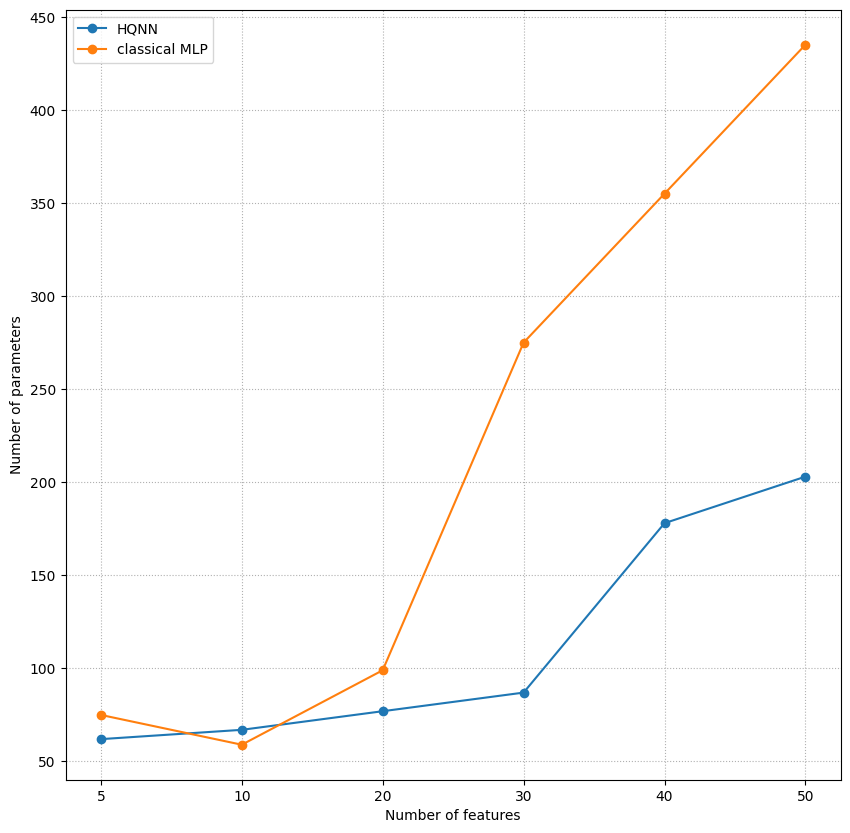

In [38]:
plt.figure(figsize=(10,10))
plt.plot(results_hqnn.keys(), results_hqnn.values(), label = "HQNN", marker = "o")
plt.plot(results_mlp.keys(), results_mlp.values(), label = "classical MLP", marker = "o")
plt.xlabel("Number of features")
plt.ylabel("Number of parameters")
plt.grid(which = "both", linestyle = "dotted")
plt.legend()
plt.show()

## Conclusion

Here, we can draw several conclusions:
* the HQNN can successfully classify the spiral dataset
* when the complexity of the data increases, the HQNN needs less parameters

Do not hesitate to push to more features to add complexity ;)

Future Directions

 1. **Scaling studies**: Test with varying number training samples and number of classes
 2. **Architecture exploration**: Try different quantum circuit designs and encoding strategies
 3. **Hardware implementation**: Evaluate on real quantum photonic hardware when available